# CNN Hyperparameters
In this notebook, you will observe the effect of various hyperparameters on the training of a deep convolutional neural network.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# data_root = "/home/space/datasets/mnist"
data_root = "./data"

In [2]:
# set the device
num_workers, pin_memory = 4, False
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal)
else:
    device = torch.device("cpu") # CPU (slowest option)

print(f"Device set to {device}!")


Device set to mps!


# Define network architecture

Implement the `__init__` and `forward` methods of the class `Net` with the same architecture as in *cnn_example.ipynb*. Add a dropout layer to the model after the second ConvLayer using **`nn.Dropout2d`** . The dropout ratio can be specified when creating the network and it should be a member variable of the class `Net`, i.e. it can be accessed by `self.dropout_ratio` inside the class. *See cnn_example.ipynb as a reference*.

In [3]:
nn.Dropout2d?

Init signature: nn.Dropout2d(p: float = 0.5, inplace: bool = False) -> None
Docstring:     
Randomly zero out entire channels.

A channel is a 2D feature map,
e.g., the :math:`j`-th channel of the :math:`i`-th sample in the
batched input is a 2D tensor :math:`\text{input}[i, j]`.

Each channel will be zeroed out independently on every forward call with
probability :attr:`p` using samples from a Bernoulli distribution.

Usually the input comes from :class:`nn.Conv2d` modules.

As described in the paper
`Efficient Object Localization Using Convolutional Networks`_ ,
if adjacent pixels within feature maps are strongly correlated
(as is normally the case in early convolution layers) then i.i.d. dropout
will not regularize the activations and will otherwise just result
in an effective learning rate decrease.

In this case, :func:`nn.Dropout2d` will help promote independence between
feature maps and should be used instead.

Args:
    p (float, optional): probability of an element to be zero-

In [4]:
F.dropout?

Signature:
F.dropout(
    input: torch.Tensor,
    p: float = 0.5,
    training: bool = True,
    inplace: bool = False,
) -> torch.Tensor
Docstring:
During training, randomly zeroes some elements of the input tensor with probability :attr:`p`.

Uses samples from a Bernoulli distribution.

See :class:`~torch.nn.Dropout` for details.

Args:
    p: probability of an element to be zeroed. Default: 0.5
    training: apply dropout if is ``True``. Default: ``True``
    inplace: If set to ``True``, will do this operation in-place. Default: ``False``
File:      ~/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py
Type:      function

In [5]:
class Net(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, dropout_ratio=0.5):
        super(Net, self).__init__()
        self.dropout_ratio = dropout_ratio
        
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv2_drop = nn.Dropout2d(p=self.dropout_ratio)
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        x = x.view(-1, 20 * 4 * 4)  # Reshape to vector
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    ### END SOLUTION

## Data loading and model setup
Implement a function `setup` that builds the data loader as well as the model and optimizer. All relevant hyperparameters parameters are parsed as optional arguments to the function. *See cnn_example.ipynb as a reference*.

In [6]:
def setup(dropout_ratio=0.5, lr=1e-2, momentum=0.5, batch_size=128, mean=0.1307, std=0.3081):
    ### BEGIN SOLUTION
    # Setup input transformation
    transformation = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((mean,), (std,))  # Standardization
                       ])

    # Setup data loader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(data_root, train=True, transform=transformation),
        batch_size=batch_size
    )
    
    model = Net(dropout_ratio=dropout_ratio).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    ### END SOLUTION
    return train_loader, device, model, optimizer

## Training
Below you are given a function that performs the training for a single epoch.

In [7]:
def train_epoch(model, device, train_loader, optimizer):
    model.train()
    
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    return losses

Setup the data loader, model and optimizer, run the training (e.g. for 3 epochs) and plot the evolution of the training loss.

Training on 60000 samples.


100%|██████████| 3/3 [00:22<00:00,  7.38s/it]


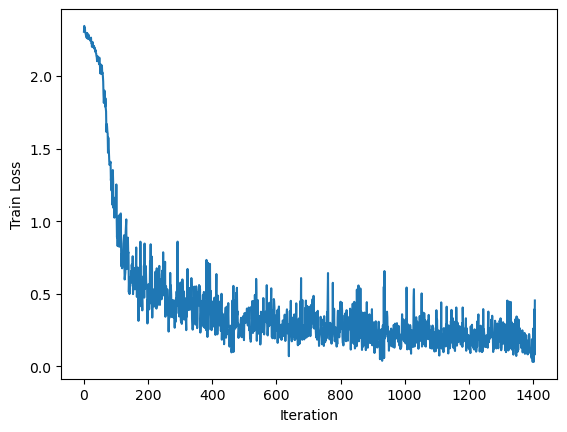

In [8]:
plt.figure()
### BEGIN SOLUTION
train_loader, device, model, optimizer = setup()
print(f"Training on {len(train_loader.dataset)} samples.")

losses = list()
for epoch in tqdm(range(3)):
    epoch_losses = train_epoch(model, device, train_loader, optimizer)
    losses.extend(epoch_losses)

# Plot the learning curve
plt.plot(losses)
### END SOLUTION
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

## Hyperparameter Tuning
Try out several values (given below) of the following hyperparameters:
* Learning rate
* Momentum
* Batch size

Visualize the learning curves in one plot for comparison.

*Optional*: Investigate the result if you assume that the data are already normalized (change the mean and standard deviation accordingly).

In [9]:
lrs = [1e0, 1e-2, 1e-4]
momenta = [0.0, 0.5, 0.9]
batch_sizes = [32, 128, 1024]  # CAVE: compare epochs, not iterations
dropout_ratios = [0.0, 0.5, 0.7]

### Learning rate

LR=1.0


100%|██████████| 3/3 [00:21<00:00,  7.17s/it]


LR=0.01


100%|██████████| 3/3 [00:21<00:00,  7.16s/it]


LR=0.0001


100%|██████████| 3/3 [00:22<00:00,  7.35s/it]


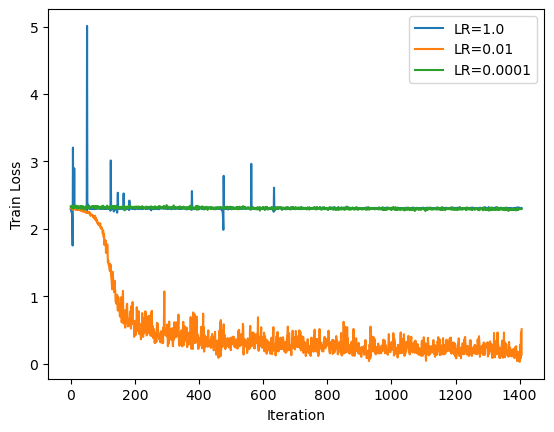

In [10]:
plt.figure()
for lr in lrs:
    ### BEGIN SOLUTION
    print(f"LR={lr}")
    train_loader, device, model, optimizer = setup(lr=lr)
    
    losses = list()
    for epoch in tqdm(range(3)):
        epoch_losses = train_epoch(model, device, train_loader, optimizer)
        losses.extend(epoch_losses)
    
    # Plot the learning curve
    plt.plot(losses, label=f"LR={lr}")
    ### END SOLUTION

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

### Momentum

momentum=0.0


100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


momentum=0.5


100%|██████████| 3/3 [00:21<00:00,  7.28s/it]


momentum=0.9


100%|██████████| 3/3 [00:21<00:00,  7.09s/it]


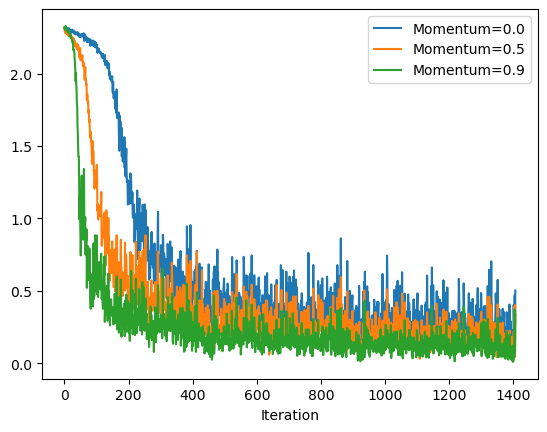

In [11]:
plt.figure()
for momentum in momenta:
    ### BEGIN SOLUTION
    print(f"momentum={momentum}")
    train_loader, device, model, optimizer = setup(momentum=momentum)
    
    losses = list()
    for epoch in tqdm(range(3)):
        epoch_losses = train_epoch(model, device, train_loader, optimizer)
        losses.extend(epoch_losses)
    
    # Plot the learning curve
    plt.plot(losses, label=f"Momentum={momentum}")
    ### END SOLUTION

plt.legend()
plt.xlabel("Iteration")
plt.show()

### Batch size

batch_size=32
batch_size=128
batch_size=1024


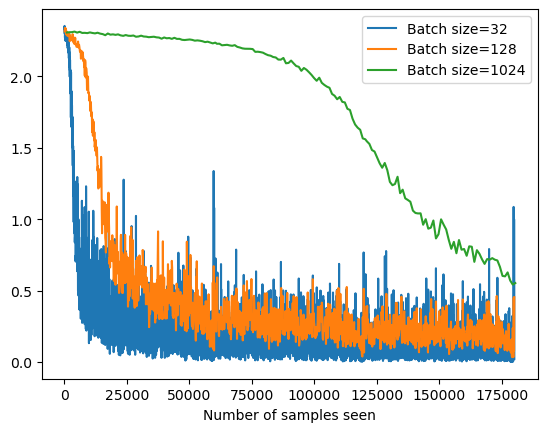

In [12]:
# Make sure you compare the losses for the same number of samples seen (not the number of iterations of gradient descent).

plt.figure()
for batch_size in batch_sizes:
    ### BEGIN SOLUTION
    print(f"batch_size={batch_size}")
    train_loader, device, model, optimizer = setup(batch_size=batch_size)
    
    losses = list()
    samples_seen = list()
    for epoch in range(3):
        epoch_losses = train_epoch(model, device, train_loader, optimizer)
        losses.extend(epoch_losses)
        samples_seen.extend([len(train_loader.dataset) * epoch + (i + 1) * batch_size for i in range(len(epoch_losses))]) 
    
    # Plot the learning curve
    plt.plot(samples_seen, losses, label=f"Batch size={batch_size}")
    ### END SOLUTION

plt.legend()
plt.xlabel("Number of samples seen")
plt.show()

## Generalization error
Even though the training loss can give valuable hints on the hyperparameters, it is typically not what we are interested in. Much more important is the performance of the model on unseen data, the so called validation/test data. Implement a data loader `test_loader` for the test data (similar to the training data loader but set the `train` parameter of `datasets.MNIST` to `False`).

In [13]:
### BEGIN SOLUTION
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(data_root, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=32)
### END SOLUTION
print(f"Evaluating on {len(test_loader.dataset)} samples.")

Evaluating on 10000 samples.


Implement an evaluation function that runs and evaluates the model. Compute the loss **and** the accuracy on the evaluation data.

In [14]:
def evaluate(model, device, data_loader):
    model.eval()
    losses = list()
    correct = 0
    num_samples = 0
    
    with torch.no_grad():  # Tell the model that we do not need gradient computation for evaluation
        for data, target in data_loader:
            # Compute output of network
            ### BEGIN SOLUTION
            data, target = data.to(device), target.to(device)
            output = model(data)
            ### END SOLUTION
            
            # Compute loss and store in list
            ### BEGIN SOLUTION
            losses.append(F.nll_loss(output, target, reduction="sum").item())
            ### END SOLUTION
            
            
            prediction = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            num_samples += len(data)

    # Compute average loss and accuracy
    ### BEGIN SOLUTION
    avg_loss = np.sum(losses) / num_samples  # If reduction="sum" is not used, here should be np.mean (not exactly correct though)
    accuracy = 100. * correct / num_samples
    ### END SOLUTION
    
    return avg_loss, accuracy

### Performance at chance level
Verify your evaluation function by running it on an untrained model on both the training and the test set. You can use the `setup` function from above to get a randomly initialized network or by calling the constructor of the `Net` class.

Which values do you expect for the test loss and accuracy?

In [15]:
### BEGIN SOLUTION
random_model = Net().to(device)
avg_train_loss, train_accuracy = evaluate(random_model, device, train_loader)
avg_test_loss, test_accuracy = evaluate(random_model, device, test_loader)
### END SOLUTION

print(f"Training set: \n \t Average loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.0f}%")
print(f"Test set: \n \t Average loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.0f}%")

Training set: 
 	 Average loss: 2.3168, Accuracy: 7%
Test set: 
 	 Average loss: 2.3173, Accuracy: 7%


### Performance on trained model
Evaluate a trained model (training procedure is provided below) on both the training and validation data.

In [16]:
train_loader, device, model, optimizer = setup()

losses = list()
for epoch in tqdm(range(10)):
    epoch_losses = train_epoch(model, device, train_loader, optimizer)
    losses.extend(epoch_losses)

100%|██████████| 10/10 [01:09<00:00,  6.99s/it]


In [17]:
### BEGIN SOLUTION
avg_train_loss, train_accuracy = evaluate(model, device, train_loader)
avg_test_loss, test_accuracy = evaluate(model, device, test_loader)
### END SOLUTION

print(f"Training set: \n \t Average loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.0f}%")
print(f"Test set: \n \t Average loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.0f}%")

Training set: 
 	 Average loss: 0.0568, Accuracy: 98%
Test set: 
 	 Average loss: 0.0524, Accuracy: 98%


### Evolution of test performance over training
Below you are given code to track and plot the test accuracy for different epochs during training.

In [18]:
train_loader, device, model, optimizer = setup(momentum=0.9)

train_losses = list()
test_losses = list()
train_accuracies = list()
test_accuracies = list()
val_epochs = list()
for epoch in tqdm(range(8)):
    # Training
    epoch_losses = train_epoch(model, device, train_loader, optimizer)
    train_losses.append(np.mean(epoch_losses))
    
    # Evaluation (only every other epoch)
    if epoch % 2 == 0:
        avg_test_losses, test_accuracy = evaluate(model, device, test_loader)
    
        test_losses.append(avg_test_losses)
        test_accuracies.append(test_accuracy) 
        val_epochs.append(epoch)

100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


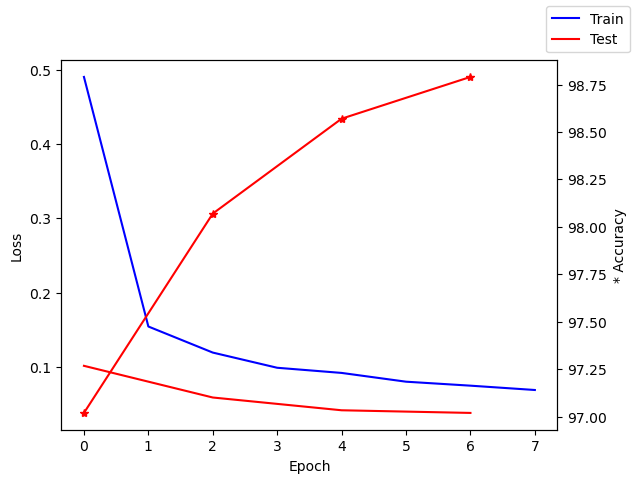

In [19]:
# Plot
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, color="b", label="Train")
ax1.plot(val_epochs, test_losses, color="r", label="Test")
ax2 = ax1.twinx()
ax2.set_ylabel('* Accuracy')
ax2.plot(val_epochs, test_accuracies, color="r", marker="*")
fig.legend()
plt.show()